This version:
* Reads data from a CSV file using pandas (Spark to come later)
* Does no preprocessing (where Spark should really help for large datasets
* Doesn't do anything about class imbalance except to look at recall and precision
* Trains both a sklearn (random forest) and a neural network (PyTorch) model
* Is not how a data scientist at a bank would build a statistically robust model

# Install and load packages

In [1]:
!pip install --upgrade pip
!pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, boto3, time, operator, requests
import numpy as np
import pandas as pd

#Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report
#import sklearn.external as joblib
#import sklearn.external.joblib as extjoblib
#import joblib
#import sklearn.external.joblib as extjoblib
import joblib

#Plotting
import matplotlib.pylab as plt
import matplotlib.colors

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Ingestion and Basic Exploration

In [5]:
df = pd.read_csv('../creditcard.csv')

In [6]:
df.shape

(142404, 31)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,118850.0,-0.900623,0.280588,-1.164185,-0.479060,2.306457,-1.109820,2.091163,-1.014135,-0.163032,...,-0.028738,0.703406,0.077963,0.410507,-0.203358,0.492114,-0.526242,-0.085891,62.34,0
1,61914.0,1.090784,-0.248195,0.569939,0.751200,-0.623526,-0.213400,-0.210090,0.086138,0.700659,...,-0.258564,-0.704155,0.081999,0.069435,0.186789,0.314808,-0.022921,0.018028,54.52,0
2,39414.0,1.123039,-0.283453,0.140288,-0.016770,-0.485220,-0.549257,-0.068658,-0.070406,0.013267,...,0.136039,0.223308,-0.190277,0.095916,0.383227,1.110139,-0.101643,0.000761,81.23,0
3,136181.0,1.979781,-0.140372,-3.090830,0.271226,2.915221,3.309011,0.035839,0.667343,0.042450,...,0.055994,0.213071,0.010282,0.708561,0.502361,-0.474254,-0.002895,-0.064011,31.65,0
4,133984.0,2.335354,-1.095306,-1.259527,-1.552168,-1.029081,-1.374204,-0.642418,-0.512668,-1.747542,...,0.084147,0.789308,0.056403,0.093860,0.128412,0.064020,-0.006132,-0.058280,15.00,0


In [8]:
print('Distribution of labels: Extreme class imbalance')
df['Class'].value_counts()

Distribution of labels: Extreme class imbalance


0    142166
1       238
Name: Class, dtype: int64

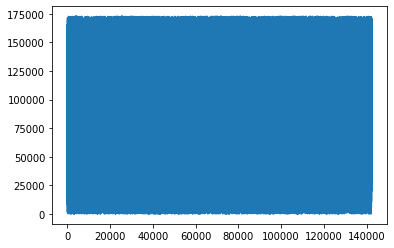

In [9]:
plt.plot(df['Time'])

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,...,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000,142404.000000
mean,94946.248273,-0.000148,-0.000094,-0.002674,-0.003948,0.001780,-0.005787,0.001443,-0.000192,0.000049,...,0.000673,0.001345,-0.000891,0.001056,-0.001327,-0.001171,-0.000020,-0.000314,88.454103,0.001671
std,47465.960339,1.949620,1.652243,1.508556,1.413065,1.374147,1.329253,1.217438,1.187849,1.101259,...,0.723052,0.725377,0.613224,0.603888,0.521120,0.481864,0.399919,0.318633,246.907421,0.040848
min,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-41.506796,-50.420090,-13.434066,...,-22.889347,-9.499423,-32.828995,-2.836627,-8.696627,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54372.750000,-0.921933,-0.601028,-0.895517,-0.849840,-0.694568,-0.771513,-0.554193,-0.209864,-0.641984,...,-0.227556,-0.543302,-0.162090,-0.353028,-0.317476,-0.327046,-0.071220,-0.053085,5.630000,0.000000
50%,84934.000000,0.013515,0.065422,0.176833,-0.023964,-0.052936,-0.279320,0.041810,0.021851,-0.051165,...,-0.029045,0.008549,-0.011382,0.040610,0.014350,-0.053482,0.001197,0.011287,21.980000,0.000000
75%,139373.500000,1.317522,0.808003,1.024905,0.734927,0.615795,0.392253,0.573250,0.327794,0.599410,...,0.186741,0.531624,0.148334,0.438298,0.349133,0.240137,0.090985,0.078742,77.000000,0.000000
max,172788.000000,2.454930,21.467203,9.382558,16.875344,34.801666,23.917837,44.054461,20.007208,15.594995,...,27.202839,8.361985,22.083545,4.016342,6.070850,3.517346,12.152401,33.847808,18910.000000,1.000000


In [11]:
df.drop('Time', inplace=True, axis=1)

In [12]:
for i in np.array(df.drop('Class', axis=1).iloc[0]): print(f'{i},')

-0.900622579042403,
0.280587861664009,
-1.16418507445319,
-0.479059833649251,
2.3064567073629303,
-1.10981977886077,
2.09116319137464,
-1.01413490027071,
-0.163032171927941,
-0.295286482355229,
-0.6298151244797501,
-0.342882001890299,
0.36842732543323,
-1.4897687211888102,
-0.5022359245827679,
-0.366396749156911,
0.405848024644247,
-0.145480303734502,
-0.0568360635252561,
-0.2952823196352719,
-0.0287383248838232,
0.703405767865118,
0.0779631730764966,
0.4105065423993879,
-0.203357971544653,
0.492113918404666,
-0.5262416695651839,
-0.0858909981161408,
62.34,


# Train-test split

In [13]:
df_train, df_test = train_test_split(df, train_size=0.8)

In [14]:
print(df_train.shape)
df_train['Class'].value_counts()

(113923, 30)


0    113729
1       194
Name: Class, dtype: int64

In [15]:
print(df_test.shape)
df_test['Class'].value_counts()

(28481, 30)


0    28437
1       44
Name: Class, dtype: int64

# Train Sklearn Random Forest Model

In [16]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=10)

model.fit(df_train.drop('Class', axis=1), df_train['Class'])

pred_train_prob = model.predict_proba(df_train.drop('Class', axis=1))
pred_test_prob = model.predict_proba(df_test.drop('Class', axis=1))

pred_train = model.predict(df_train.drop('Class', axis=1))
pred_test = model.predict(df_test.drop('Class', axis=1))

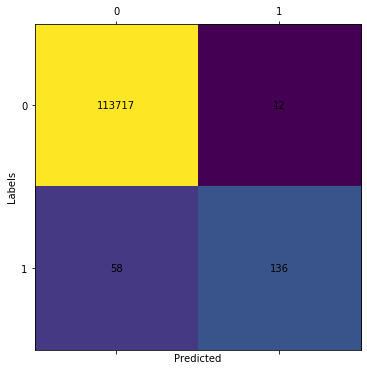

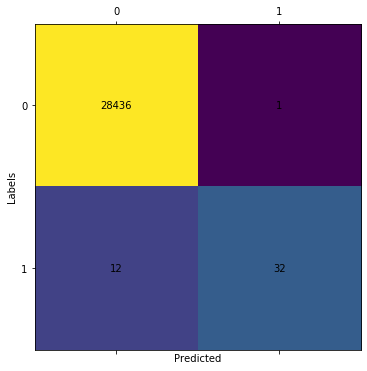

In [17]:
def plot_confusion_matrix(df, pred):
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()

    unique_labels = df['Class'].unique()
    N = len(unique_labels)
    confusion = confusion_matrix(df['Class'], pred)
    ax.matshow(np.log(confusion + 1.001))

    ax.set_xticks(range(N))
    ax.set_yticks(range(N))

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    for i in range(N):
        for j in range(N):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('Predicted')
    plt.ylabel('Labels')

plot_confusion_matrix(df_train, pred_train);
plot_confusion_matrix(df_test, pred_test)

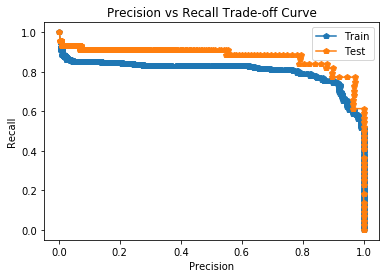

In [18]:
def plot_precision_recall_curve(df, pred_prob, label):
    precision, recall, thresholds = precision_recall_curve(df['Class'], pred_prob[:,1])
    plt.plot(precision, recall, 'p-', label=label)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision vs Recall Trade-off Curve')
    plt.grid()
    plt.legend()
    
plot_precision_recall_curve(df_train, pred_train_prob, 'Train')
plot_precision_recall_curve(df_test, pred_test_prob, 'Test')

# Train PyTorch Neural Network Model

In [19]:
N_hidden = 128
N_output = 1

net = nn.Sequential(nn.Linear(df_train.shape[1]-1, N_hidden),
                    nn.ReLU(),
                    nn.Linear(N_hidden, N_output),
                    #nn.Sigmoid()
                   )

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCEWithLogitsLoss()

class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.N_cols = df.shape[1]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        x = np.array(self.df.iloc[ix])
        features = x[:(self.N_cols-1)] #exclude time, Class
        label = x[[-1]]
        
        #return {'features': torch.from_numpy(features), 'label': torch.from_numpy(label)}
        return (torch.from_numpy(features).float(), torch.from_numpy(label))
    

In [20]:
BATCH_SIZE = 128

ds_torch_train = CCDataset(df_train)
ds_torch_test = CCDataset(df_test)

dl_torch_train = DataLoader(ds_torch_train, batch_size=128, num_workers=0)
dl_torch_test = DataLoader(ds_torch_test, batch_size=128, num_workers=0)

In [21]:
print(ds_torch_train[0])
print(df_train.iloc[0])

(tensor([-2.2561, -0.9840,  2.9719,  5.2775,  0.6674,  1.5969, -2.1270,  1.2347,
        -0.6331,  0.6442, -2.3029,  0.4260,  1.4063, -1.0871, -1.0649, -0.2254,
         0.7275,  0.5567,  1.6580,  0.8400,  0.3257,  0.5650, -0.3279,  0.5668,
         0.2060,  0.6174,  0.1068, -0.2638, 21.9300]), tensor([0.], dtype=torch.float64))
V1        -2.256076
V2        -0.984010
V3         2.971872
V4         5.277482
V5         0.667358
V6         1.596876
V7        -2.127023
V8         1.234717
V9        -0.633103
V10        0.644217
V11       -2.302882
V12        0.425963
V13        1.406350
V14       -1.087106
V15       -1.064883
V16       -0.225411
V17        0.727527
V18        0.556734
V19        1.657962
V20        0.840038
V21        0.325690
V22        0.564969
V23       -0.327856
V24        0.566808
V25        0.205981
V26        0.617354
V27        0.106761
V28       -0.263768
Amount    21.930000
Class      0.000000
Name: 57362, dtype: float64


In [22]:
def train_model(train_dl, test_dl, model, criterion, N_epochs, print_freq, lr=1e-3):
    '''Loop over dataset in batches, compute loss, backprop and update weights
    '''
    
    model.train() #switch to train model (for dropout, batch normalization etc.)
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    avg_precision_dict, loss_dict = {}, {}
    for epoch in range(N_epochs): #loop over epochs i.e. sweeps over full data
        curr_loss = 0
        N = 0
        
        for idx, (features, labels) in enumerate(train_dl): #loop over batches
            features = features.to(device)
            labels = labels.to(device)
            
            preds = model(features)
            loss = criterion(preds.squeeze(), labels.squeeze().float())
            
            curr_loss += loss.item() #accumulate loss
            N += len(labels) #accumulate number of data points seen in this epoch
                
            #backprop and updates
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % print_freq == 0 or epoch==N_epochs-1:
            val_loss, val_avg_precision = validate(test_dl, model, criterion) #get model perf metrics from test set
            
            avg_precision_dict[epoch] = val_avg_precision
            loss_dict[epoch] = val_loss
            
            print(f'Iter = {epoch} Train Loss = {curr_loss / N} val_loss = {val_loss} val_avg_precision = {val_avg_precision}')
            
    return model, avg_precision_dict, loss_dict

def validate(test_dl, model, criterion):
    '''Loop over test dataset and compute loss and accuracy
    '''
    model.eval() #switch to eval model
    
    loss = 0
    N = 0

    preds_all, labels_all = torch.tensor([]), torch.tensor([])
    
    with torch.no_grad(): #no need to keep variables for backprop computations
        for idx, (features, labels) in enumerate(test_dl):
            features = features.to(device)
            labels = labels.to(device).float()
            
            preds = model(features)
            
            preds_all = torch.cat((preds_all, preds.to('cpu')), 0)
            labels_all = torch.cat((labels_all, labels.to('cpu')), 0)
            
            loss += criterion(preds.squeeze(), labels.squeeze()) #cumulative loss
            N += len(labels)
    
    avg_precision = average_precision_score(labels_all.squeeze().numpy(), preds_all.squeeze().numpy())
    
    return loss / N, avg_precision

In [23]:
model, avg_precision_dict, loss_dict = train_model(dl_torch_train, dl_torch_test, net, criterion, 10, 1, lr=1e-3)

Iter = 0 Train Loss = 0.0002774604794987474 val_loss = 2.89320796582615e-05 val_avg_precision = 0.7311661756934397
Iter = 1 Train Loss = 7.656031344969048e-05 val_loss = 2.035665966104716e-05 val_avg_precision = 0.7952682296671908
Iter = 2 Train Loss = 7.617026348516797e-05 val_loss = 1.747338865243364e-05 val_avg_precision = 0.8793259124227613
Iter = 3 Train Loss = 6.601130089446114e-05 val_loss = 1.5286468624253757e-05 val_avg_precision = 0.893850515836287
Iter = 4 Train Loss = 4.594949278655557e-05 val_loss = 1.5416992027894594e-05 val_avg_precision = 0.8922384673204106
Iter = 5 Train Loss = 4.93616823052204e-05 val_loss = 1.4137604921415914e-05 val_avg_precision = 0.8941180844663354
Iter = 6 Train Loss = 5.810191060208501e-05 val_loss = 1.453649383620359e-05 val_avg_precision = 0.8979032297093408
Iter = 7 Train Loss = 7.960086712181464e-05 val_loss = 2.7233472792431712e-05 val_avg_precision = 0.8280993599369703
Iter = 8 Train Loss = 5.9059940621597815e-05 val_loss = 1.3110118743497

In [24]:
#NEED TO DEBUG THIS
#criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1., 1000.]))
#model, avg_precision_dict, loss_dict = train_model(dl_torch_train, dl_torch_test, net, criterion_weighted, 10, 1, lr=1e-3)

# Export to Script

For many tools, hyperparameter tuning using Katib for example, we will need a script that can accept command line arguments and package it in an image. Since many data scientists prefer using Jupyter notebooks, we'll add this section to write a main function and convert it to a script. An alternative is to do your development work in scripts and import the scripts in a notebook.

### Single node script

The cell below writes the contents to a file called ccfraud.py. It doesn't execute the contents in the cell.

The training is done on a single physical node with the only parallelization possible being one across threads on the processor on the node and on an attached GPU.

For parallelization by splitting the data (but not the model) across multiple physical nodes, please see the next example below.

In [25]:
%%writefile ccfraud.py

import os, boto3, time, operator, requests
import numpy as np
import pandas as pd
import argparse

#Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report
from sklearn.externals import joblib

#Plotting
import matplotlib.pylab as plt
import matplotlib.colors

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_architecture(df_train, N_hidden=128):
    '''Wrapper around the neural net architecture
    '''
    N_output = 1

    net = nn.Sequential(nn.Linear(df_train.shape[1]-1, N_hidden),
                        nn.ReLU(),
                        nn.Linear(N_hidden, N_output),
                        #nn.Sigmoid()
                       )
    
    return net


def get_criterion(weighted=False, pos_weight=torch.tensor([1,1])):
    '''Wrapper around criterion
    '''
    if not weighted:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #NEEDS DEBUGGING
        
    return criterion
        
class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.N_cols = df.shape[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        x = np.array(self.df.iloc[ix])
        features = x[:(self.N_cols-1)] #exclude time, Class
        label = x[[-1]]

        #return {'features': torch.from_numpy(features), 'label': torch.from_numpy(label)}
        return (torch.from_numpy(features).float(), torch.from_numpy(label))
    

def train_model(train_dl, test_dl, model, criterion, N_epochs, print_freq, lr=1e-3, optimizer='adam'):
    '''Loop over dataset in batches, compute loss, backprop and update weights
    '''
    
    model.train() #switch to train model (for dropout, batch normalization etc.)
    
    model = model.to(device)
    if optimizer=='adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print("Using adam")
    elif optimizer=='sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)
        print("Using sgd")
    else:
        raise ValueError("Please use either adam or sgd")
    
    avg_precision_dict, loss_dict = {}, {}
    for epoch in range(N_epochs): #loop over epochs i.e. sweeps over full data
        curr_loss = 0
        N = 0
        
        for idx, (features, labels) in enumerate(train_dl): #loop over batches
            features = features.to(device)
            labels = labels.to(device)
            
            preds = model(features)
            loss = criterion(preds.squeeze(), labels.squeeze().float())
            
            curr_loss += loss.item() #accumulate loss
            N += len(labels) #accumulate number of data points seen in this epoch
                
            #backprop and updates
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % print_freq == 0 or epoch==N_epochs-1:
            val_loss, val_avg_precision = validate(test_dl, model, criterion) #get model perf metrics from test set
            
            avg_precision_dict[epoch] = val_avg_precision
            loss_dict[epoch] = val_loss
            
            print(f'Iter = {epoch} Train Loss = {curr_loss / N} val_loss = {val_loss} val_avg_precision = {val_avg_precision}')
            
    return model, avg_precision_dict, loss_dict

def validate(test_dl, model, criterion):
    '''Loop over test dataset and compute loss and accuracy
    '''
    model.eval() #switch to eval model
    
    loss = 0
    N = 0

    preds_all, labels_all = torch.tensor([]), torch.tensor([])
    
    with torch.no_grad(): #no need to keep variables for backprop computations
        for idx, (features, labels) in enumerate(test_dl):
            features = features.to(device)
            labels = labels.to(device).float()
            
            preds = model(features)
            
            preds_all = torch.cat((preds_all, preds.to('cpu')), 0)
            labels_all = torch.cat((labels_all, labels.to('cpu')), 0)
            
            loss += criterion(preds.squeeze(), labels.squeeze()) #cumulative loss
            N += len(labels)
    
    avg_precision = average_precision_score(labels_all.squeeze().numpy(), preds_all.squeeze().numpy())
    
    return loss / N, avg_precision

def main():
    parser = argparse.ArgumentParser(description='Credit Card Fraud Detection')
    
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='batch size for training (default = 64)')

    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')

    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 10)')

    parser.add_argument('--n-hidden', type=int, default=16, metavar='N',
                        help='number of nodes in hidden layers')

    parser.add_argument('--optimizer', type=str, default='adam', metavar='N',
                        help='optimizer to use: "adam" or "sgd"')
    
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')

    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')

    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    
    parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    
    parser.add_argument('--dir', default='logs', metavar='L',
                        help='directory where summary logs are stored')
  

    
    args = parser.parse_args()
    
    batch_size = args.batch_size
    N_epochs = args.epochs
    lr = args.lr
    N_print = args.log_interval
    N_hidden = args.n_hidden
    optimizer = args.optimizer
    
    #Read data and preprocessing
    df = pd.read_csv('creditcard.csv')
    df.drop('Time', inplace=True, axis=1)

    # Train-test split
    df_train, df_test = train_test_split(df, train_size=0.8)

    ds_torch_train = CCDataset(df_train)
    ds_torch_test = CCDataset(df_test)

    dl_torch_train = DataLoader(ds_torch_train, batch_size=batch_size, num_workers=0)
    dl_torch_test = DataLoader(ds_torch_test, batch_size=batch_size, num_workers=0)

    #Network architecture and criterion
    net = get_architecture(df_train, N_hidden=N_hidden)
    criterion = get_criterion()
    print(net)
    print(f"Learning rate: {lr}")
    
    net, avg_precision_dict, loss_dict = train_model(dl_torch_train, dl_torch_test, net, criterion, N_epochs, N_print, lr=lr, optimizer=optimizer)

if __name__=='__main__':
    main()

Overwriting ccfraud.py


### Multiple nodes script

The cell below writes the contents to a file called ccfraud_distributed.py. It doesn't execute the contents in the cell.

The training is done across multiple physical nodes. torch.distributed has a range of options for distributing across both a single physical node with multiple GPUs as well as across multiple physical nodes either by having each node compute gradients on a fraction of the data or even by having subsets of the model across different nodes.

Example: https://github.com/kubeflow/pytorch-operator/blob/master/examples/mnist/mnist.py

torch.distributed: start here https://pytorch.org/tutorials/beginner/dist_overview.html

In [26]:
%%writefile ccfraud_distributed.py

import os, boto3, time, operator, requests
import numpy as np
import pandas as pd
import argparse

#Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report
from sklearn.externals import joblib

#Plotting
import matplotlib.pylab as plt
import matplotlib.colors

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributed as dist

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
WORLD_SIZE = int(os.environ.get('WORLD_SIZE', 1))
print(f'WORLD_SIZE = {WORLD_SIZE}')

def get_architecture(df_train, N_hidden=128):
    '''Wrapper around the neural net architecture
    '''
    N_output = 1

    net = nn.Sequential(nn.Linear(df_train.shape[1]-1, N_hidden),
                        nn.ReLU(),
                        nn.Linear(N_hidden, N_output),
                        #nn.Sigmoid()
                       )
    
    return net


def get_criterion(weighted=False, pos_weight=torch.tensor([1,1])):
    '''Wrapper around criterion
    '''
    if not weighted:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #NEEDS DEBUGGING
        
    return criterion
        
class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.N_cols = df.shape[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        x = np.array(self.df.iloc[ix])
        features = x[:(self.N_cols-1)] #exclude time, Class
        label = x[[-1]]

        #return {'features': torch.from_numpy(features), 'label': torch.from_numpy(label)}
        return (torch.from_numpy(features).float(), torch.from_numpy(label))
    
def train_model(train_dl, test_dl, model, criterion, N_epochs, print_freq, lr=1e-3, optimizer='adam'):
    '''Loop over dataset in batches, compute loss, backprop and update weights
    '''
    
    model.train() #switch to train model (for dropout, batch normalization etc.)
    
    model = model.to(device)
    if optimizer=='adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print("Using adam")
    elif optimizer=='sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)
        print("Using sgd")
    else:
        raise ValueError("Please use either adam or sgd")
    
    avg_precision_dict, loss_dict = {}, {}
    for epoch in range(N_epochs): #loop over epochs i.e. sweeps over full data
        curr_loss = 0
        N = 0
        
        for idx, (features, labels) in enumerate(train_dl): #loop over batches
            features = features.to(device)
            labels = labels.to(device)
            
            preds = model(features)
            loss = criterion(preds.squeeze(), labels.squeeze().float())
            
            curr_loss += loss.item() #accumulate loss
            N += len(labels) #accumulate number of data points seen in this epoch
                
            #backprop and updates
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % print_freq == 0 or epoch==N_epochs-1:
            val_loss, val_avg_precision = validate(test_dl, model, criterion) #get model perf metrics from test set
            
            avg_precision_dict[epoch] = val_avg_precision
            loss_dict[epoch] = val_loss
            
            print(f'Iter = {epoch} Train Loss = {curr_loss / N} val_loss = {val_loss} val_avg_precision = {val_avg_precision}')
            
    return model, avg_precision_dict, loss_dict

def validate(test_dl, model, criterion):
    '''Loop over test dataset and compute loss and accuracy
    '''
    model.eval() #switch to eval model
    
    loss = 0
    N = 0

    preds_all, labels_all = torch.tensor([]), torch.tensor([])
    
    with torch.no_grad(): #no need to keep variables for backprop computations
        for idx, (features, labels) in enumerate(test_dl):
            features = features.to(device)
            labels = labels.to(device).float()
            
            preds = model(features)
            
            preds_all = torch.cat((preds_all, preds.to('cpu')), 0)
            labels_all = torch.cat((labels_all, labels.to('cpu')), 0)
            
            loss += criterion(preds.squeeze(), labels.squeeze()) #cumulative loss
            N += len(labels)
    
    avg_precision = average_precision_score(labels_all.squeeze().numpy(), preds_all.squeeze().numpy())
    
    return loss / N, avg_precision

def should_distribute():
    return dist.is_available() and WORLD_SIZE > 1
    
def is_distributed():
    return dist.is_available() and dist.is_initialized()
    
def main():
    parser = argparse.ArgumentParser(description='Credit Card Fraud Detection')
    
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='batch size for training (default = 64)')

    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')

    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 10)')

    parser.add_argument('--n-hidden', type=int, default=16, metavar='N',
                        help='number of nodes in hidden layers')

    parser.add_argument('--optimizer', type=str, default='adam', metavar='N',
                        help='optimizer to use: "adam" or "sgd"')
    
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')

    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')

    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    
    parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    
    parser.add_argument('--dir', default='logs', metavar='L',
                        help='directory where summary logs are stored')
  

    
    args = parser.parse_args()
    
    batch_size = args.batch_size
    N_epochs = args.epochs
    lr = args.lr
    N_print = args.log_interval
    N_hidden = args.n_hidden
    optimizer = args.optimizer
        
    #distributed
    if should_distribute():
        dist.init_process_group(dist.Backend.GLOO)
        print('Using distributed PyTorch with backend GLOO')
    
    #Read data and preprocessing
    df = pd.read_csv('creditcard.csv')
    df.drop('Time', inplace=True, axis=1)

    # Train-test split
    df_train, df_test = train_test_split(df, train_size=0.8)

    ds_torch_train = CCDataset(df_train)
    ds_torch_test = CCDataset(df_test)

    dl_torch_train = DataLoader(ds_torch_train, batch_size=batch_size, num_workers=0)
    dl_torch_test = DataLoader(ds_torch_test, batch_size=batch_size, num_workers=0)

    #Network architecture and criterion
    net = get_architecture(df_train, N_hidden=N_hidden)
    criterion = get_criterion()
    print(net)
    print(f"Learning rate: {lr}")
    
    if is_distributed():
        Distributor = nn.parallel.DistributedDataParallelCPU
        net = Distributor(net)
    
    net, avg_precision_dict, loss_dict = train_model(dl_torch_train, dl_torch_test, net, criterion, N_epochs, N_print, lr=lr, optimizer=optimizer)
    
    
if __name__=='__main__':
    main()

Overwriting ccfraud_distributed.py


### Serving Single Node Script

In [30]:
%%writefile ccfraud_serving.py

import os, boto3, time, operator, requests
import numpy as np
import pandas as pd
import argparse

#Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_recall_curve,\
                            average_precision_score,\
                            roc_auc_score, roc_curve,\
                            confusion_matrix, classification_report
from sklearn.externals import joblib

#Plotting
import matplotlib.pylab as plt
import matplotlib.colors

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Net(nn.Module):
    def __init__(self, df_train, N_hidden=128):
        super(Net, self).__init__()
        
        self.N_input = df_train.shape[1]-1
        self.N_output = 1
        
        self.layer1 = nn.Linear(self.N_input, N_hidden)
        self.layer2 = nn.Linear(N_hidden, self.N_output)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.layer2(self.act(self.layer1(x)))
        
        return x


def get_criterion(weighted=False, pos_weight=torch.tensor([1,1])):
    '''Wrapper around criterion
    '''
    if not weighted:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #NEEDS DEBUGGING
        
    return criterion
        
class CCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.N_cols = df.shape[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        x = np.array(self.df.iloc[ix])
        features = x[:(self.N_cols-1)] #exclude time, Class
        label = x[[-1]]

        #return {'features': torch.from_numpy(features), 'label': torch.from_numpy(label)}
        return (torch.from_numpy(features).float(), torch.from_numpy(label))
    

def train_model(train_dl, test_dl, model, criterion, N_epochs, print_freq, lr=1e-3, optimizer='adam'):
    '''Loop over dataset in batches, compute loss, backprop and update weights
    '''
    
    model.train() #switch to train model (for dropout, batch normalization etc.)
    
    model = model.to(device)
    if optimizer=='adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print("Using adam")
    elif optimizer=='sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)
        print("Using sgd")
    else:
        raise ValueError("Please use either adam or sgd")
    
    avg_precision_dict, loss_dict = {}, {}
    for epoch in range(N_epochs): #loop over epochs i.e. sweeps over full data
        curr_loss = 0
        N = 0
        
        for idx, (features, labels) in enumerate(train_dl): #loop over batches
            features = features.to(device)
            labels = labels.to(device)
            
            preds = model(features)
            loss = criterion(preds.squeeze(), labels.squeeze().float())
            
            curr_loss += loss.item() #accumulate loss
            N += len(labels) #accumulate number of data points seen in this epoch
                
            #backprop and updates
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % print_freq == 0 or epoch==N_epochs-1:
            val_loss, val_avg_precision = validate(test_dl, model, criterion) #get model perf metrics from test set
            
            avg_precision_dict[epoch] = val_avg_precision
            loss_dict[epoch] = val_loss
            
            print(f'Iter = {epoch} Train Loss = {curr_loss / N} val_loss = {val_loss} val_avg_precision = {val_avg_precision}')
            
    return model, avg_precision_dict, loss_dict

def validate(test_dl, model, criterion):
    '''Loop over test dataset and compute loss and accuracy
    '''
    model.eval() #switch to eval model
    
    loss = 0
    N = 0

    preds_all, labels_all = torch.tensor([]), torch.tensor([])
    
    with torch.no_grad(): #no need to keep variables for backprop computations
        for idx, (features, labels) in enumerate(test_dl):
            features = features.to(device)
            labels = labels.to(device).float()
            
            preds = model(features)
            
            preds_all = torch.cat((preds_all, preds.to('cpu')), 0)
            labels_all = torch.cat((labels_all, labels.to('cpu')), 0)
            
            loss += criterion(preds.squeeze(), labels.squeeze()) #cumulative loss
            N += len(labels)
    
    avg_precision = average_precision_score(labels_all.squeeze().numpy(), preds_all.squeeze().numpy())
    
    return loss / N, avg_precision

def main():
    parser = argparse.ArgumentParser(description='Credit Card Fraud Detection')
    
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='batch size for training (default = 64)')

    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')

    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 10)')

    parser.add_argument('--n-hidden', type=int, default=16, metavar='N',
                        help='number of nodes in hidden layers')

    parser.add_argument('--optimizer', type=str, default='adam', metavar='N',
                        help='optimizer to use: "adam" or "sgd"')
    
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')

    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')

    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    
    parser.add_argument('--log-interval', type=int, default=1, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    
    parser.add_argument('--dir', default='logs', metavar='L',
                        help='directory where summary logs are stored')
  

    
    args = parser.parse_args()
    
    batch_size = args.batch_size
    N_epochs = args.epochs
    lr = args.lr
    N_print = args.log_interval
    N_hidden = args.n_hidden
    optimizer = args.optimizer
    
    #Read data and preprocessing
    df = pd.read_csv('creditcard.csv')
    df.drop('Time', inplace=True, axis=1)

    # Train-test split
    df_train, df_test = train_test_split(df, train_size=0.8)

    ds_torch_train = CCDataset(df_train)
    ds_torch_test = CCDataset(df_test)

    dl_torch_train = DataLoader(ds_torch_train, batch_size=batch_size, num_workers=0)
    dl_torch_test = DataLoader(ds_torch_test, batch_size=batch_size, num_workers=0)

    #Network architecture and criterion
    net = Net(df_train, N_hidden=N_hidden)
    criterion = get_criterion()
    print(net)
    print(f"Learning rate: {lr}")
    
    net, avg_precision_dict, loss_dict = train_model(dl_torch_train, dl_torch_test, net, criterion, N_epochs, N_print, lr=lr, optimizer=optimizer)

    net.eval()
    torch.save(net.state_dict(), "model.pt")
    
if __name__=='__main__':
    main()

Overwriting ccfraud_serving.py


# Check the Important Features

In [31]:
%matplotlib inline
import operator
import matplotlib.pylab as plt

feat_imp = sorted(zip(features_train_pd.columns, model.feature_importances_), key=operator.itemgetter(1), reverse=True)
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in feat_imp], [i[1] for i in feat_imp], 'p-')
_ = plt.xticks(rotation=90)

NameError: name 'features_train_pd' is not defined

# Re-create the model with Important Features

In [32]:
#Define features and target variables for convenience.
## From the graph we only want seven important features V3,V4,V10,V11,V12,V14,V17
drop_time_class = ['_c0', 'Time', 'Class','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
drop_class=['Class']


features_train = df_train.drop(*drop_time_class)
target_train = df_train.select("Class")

features_test = df_test.drop(*drop_time_class)
target_test = df_test.select("Class")
features_test.printSchema()

model = RandomForestClassifier(n_estimators=200, max_depth=6, n_jobs=10, class_weight='balanced')
                               
#Convert to pandas
features_test_pd = features_test.toPandas()
target_test_pd = target_test.toPandas()

features_train_pd = features_train.toPandas()
target_train_pd = target_train.toPandas()

model.fit(features_train_pd, target_train_pd.values.ravel())

pred_train = model.predict(features_train_pd)
pred_test = model.predict(features_test_pd)

pred_train_prob = model.predict_proba(features_train_pd)
pred_test_prob = model.predict_proba(features_test_pd)

print("Number of features")
print(len(model.feature_importances_))
  
#save mode in filesystem
joblib.dump(model, 'model.pkl') 

TypeError: drop() takes from 1 to 8 positional arguments but 25 were given

# Confusion Matrix

In [33]:
_ = plot_confusion_matrix(target_train_pd, model.predict(features_train_pd))

_ = plot_confusion_matrix(target_test_pd, model.predict(features_test_pd))

NameError: name 'target_train_pd' is not defined

# Test New Model

In [34]:
import json
import pandas as pd
import numpy as np
import time


df_test_pandas = df_test.toPandas()
fraudTest = df_test_pandas.loc[df_test_pandas['Class']== 1]
notFraudTest = df_test_pandas.loc[df_test_pandas['Class']== 0]

fraudTestFeatures = fraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
notFraudTestFeatures = notFraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])

for index, row in fraudTestFeatures.iterrows():
    data = row
    rowdf = pd.DataFrame([data.tolist()], columns = ['V3','V4','V10','V11','V12','V14','V17','Amount'])
    print(model.predict(rowdf))
    time.sleep(2)




AttributeError: 'DataFrame' object has no attribute 'toPandas'

# Upload Model to Rook/Ceph

In [ ]:
import boto3

key = "uploaded/model.pkl"
s3.upload_file(Bucket=s3_bucket, Key=key, Filename="model.pkl")
prefix='uploaded/'
result = s3.list_objects(Bucket=s3_bucket, Prefix=prefix, Delimiter='/')
print(result)

# Install OpenShift client

In [ ]:
%%bash
curl -o oc.tar.gz -L https://mirror.openshift.com/pub/openshift-v4/x86_64/clients/ocp/4.8.5/openshift-client-linux-4.8.5.tar.gz
tar xzf oc.tar.gz
cp oc ~/../bin/oc

# Login into Cluster

In [ ]:
%%bash

oc login -u admin -p opennaru --insecure-skip-tls-verify https://api.openmaru.ocp482.com:6443
oc project frauddetection

# Serve Model With Seldon

In [ ]:
%%bash
oc project frauddetection
oc create -n frauddetection -f https://raw.githubusercontent.com/nakfour/odh-kubeflow/master/mymodel.json
oc get seldondeployments

# Test Served Full Model in Curl

In [ ]:
%%bash
curl -o jq -L https://github.com/stedolan/jq/releases/download/jq-1.6/jq-linux64
cp jq ~/../bin/jq
chmod 777 ~/../bin/jq
export TOKENJSON=$(curl -XPOST -u oauth-key:oauth-secret <INSERT SELDON API SERVER URL>/oauth/token -d 'grant_type=client_credentials')
export TOKEN=$(echo $TOKENJSON | jq ".access_token" -r)
echo $TOKEN

curl -v --header "Authorization: Bearer $TOKEN" <INSERT SELDON API SERVER URL>/api/v0.1/predictions -d '{"strData": "0.365194527642578,0.819750231339882,-0.5927999453145171,-0.619484351930421,-2.84752569239798,1.48432160780265,0.499518887687186,72.98"}' -H "Content-Type: application/json"

# Test Served Full Model In Python

In [ ]:
### Testing the served model from python using the test dataframe
import requests
import time

# Get the token
post_data = {"grant_type": "client_credentials"}
requestOauth = requests.post('<INSERT SELDON API SERVER URL>/oauth/token', auth=('oauth-key', 'oauth-secret'), data=post_data, json={'grant_type=client_credentials'})

data = requestOauth.json();
print(data['access_token'])
access_token = data['access_token']

headers = {'Content-type': 'application/json', 'Authorization': 'Bearer {}'.format(access_token)}
#Read the test dataframe and stream each row
df_test_pandas = df_test.toPandas()
fraudTest = df_test_pandas.loc[df_test_pandas['Class']== 1]
notFraudTest = df_test_pandas.loc[df_test_pandas['Class']== 0]

fraudTestFeatures = fraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
notFraudTestFeatures = notFraudTest.drop(columns=['Time','Class', '_c0','V1','V2','V5','V6','V7','V8','V9','V13','V15','V16','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'])
#for index, row in features_test.toPandas().iterrows():
for index, row in fraudTestFeatures.iterrows():
    data = row
    str1 = ','.join(str(e) for e in  data)
    requestPrediction = requests.post('<INSERT SELDON API SERVER URL>/api/v0.1/predictions', headers=headers, json={"strData": str1 })
    predictionData = requestPrediction.json();
    datafield = predictionData['data']
    predictionArray = datafield['ndarray']
    print(predictionArray[0])
    time.sleep(2)

# Clear Demo

In [ ]:
#%%bash
#oc project frauddetection
#oc delete seldondeployments mymodel

